This notebook provides simple code and explanations to open the LLC4320 dataset, perform simple operations for plotting, and a function to subset an n_deg by n_deg spatial box of data about a center_lon, center_lat.

In [2]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zarr
import dask

In [3]:
# open llc
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

In [6]:
# open lazy llc dataset structure
llc

<xarray.Dataset> Size: 3PB
Dimensions:   (time: 10311, face: 13, j: 4320, i: 4320, i_g: 4320, k: 51,
               j_g: 4320, k_l: 51, k_p1: 52, k_u: 51)
Coordinates:
  * i         (i) int16 9kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g       (j_g) int16 9kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j         (j) int16 9kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g       (i_g) int16 9kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * k_u       (k_u) int64 408B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * k_l       (k_l) int64 408B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 82kB 2011-09-13 ... 2012-11-15T14:00:00
  * face      (face) int16 26B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k         (k) int16 102B 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_p1      (k_p1) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51
Data variables: (12/55)
    SIarea    (time, face, j, i) float32 10TB dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>
    dyG       (face, j, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    hFacS     (k, face, j_g, i) float32 49GB dask.array<chunksize=(51, 1, 720, 720), meta=np.ndarray>
    Depth     (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    PHrefC    (k) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    Zl        (k_l) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    ...        ...
    oceSflux  (time, face, j, i) float32 10TB dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>
    W         (time, k_p1, face, j, i) float32 520TB dask.array<chunksize=(1, 52, 1, 720, 720), meta=np.ndarray>
    dxF       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rhoRef    (k) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    SIvice    (time, face, j_g, i) float32 10TB dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>
    Eta       (time, face, j, i) float32 10TB dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>

In [8]:
total_bytes = llc.nbytes

# Convert to Petabytes (Decimal: 1 PB = 10^15 bytes)
size_in_pb = total_bytes / 1e15

# Convert to Pebibytes (Binary: 1 PiB = 2^50 bytes)
#size_in_pib = total_bytes / (1024**5)

print(f"Dataset Size: {size_in_pb:.4f} PB")
#print(f"Dataset Size: {size_in_pib:.4f} PiB")

Dataset Size: 2.7119 PB


See above that the data is spatially organized into 13 faces each sub-indexed by i,j with shape (0:4320, 0:4320). Vertically, the dataset is organized by k (depth indice).\
\
With respect to variables, important features include temperature and salinity(Theta, Salt), horizontal and vertical velocities (U,V,W), and boundary vars such as Eta and oceQnet (free surface height, net surface heat flux).\
\
For a complete list of grid metrics, indices, state and surface variables/fluxes, sea-ice variables, and diagnostics/ref constants/masks, scroll to the bottom of this notebook

Let's select different subsets of the data and plot

In [4]:
# first define a helper function to rotate plots for N-S/vertical alignment
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.1 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons

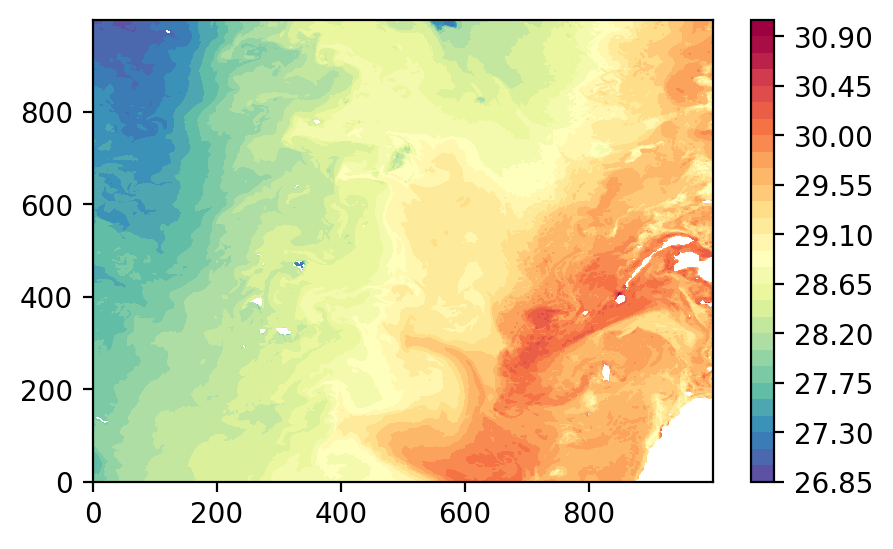

In [12]:
# select face 7, which is the North Pacific, depth = surface, and time = 3000 hours
llc_sub = llc.isel(face=8, k = 0, time = 3000, i=slice(0,1000),j=slice(0,1000))

# let's plot
fig, ax = plt.subplots(figsize=(5,3),dpi=200)
cf = ax.contourf(llc_sub['Theta']['i'], llc_sub['Theta']['j'], llc_sub['Theta'], cmap="Spectral_r",vmin=np.min(llc_sub['Theta']).values,vmax=np.max(llc_sub['Theta']).values, levels = 30)

plt.colorbar(cf, ax = ax)
#ax.set_xlim(0,4320)

#rotate_axes_90_clockwise(ax)

plt.show()

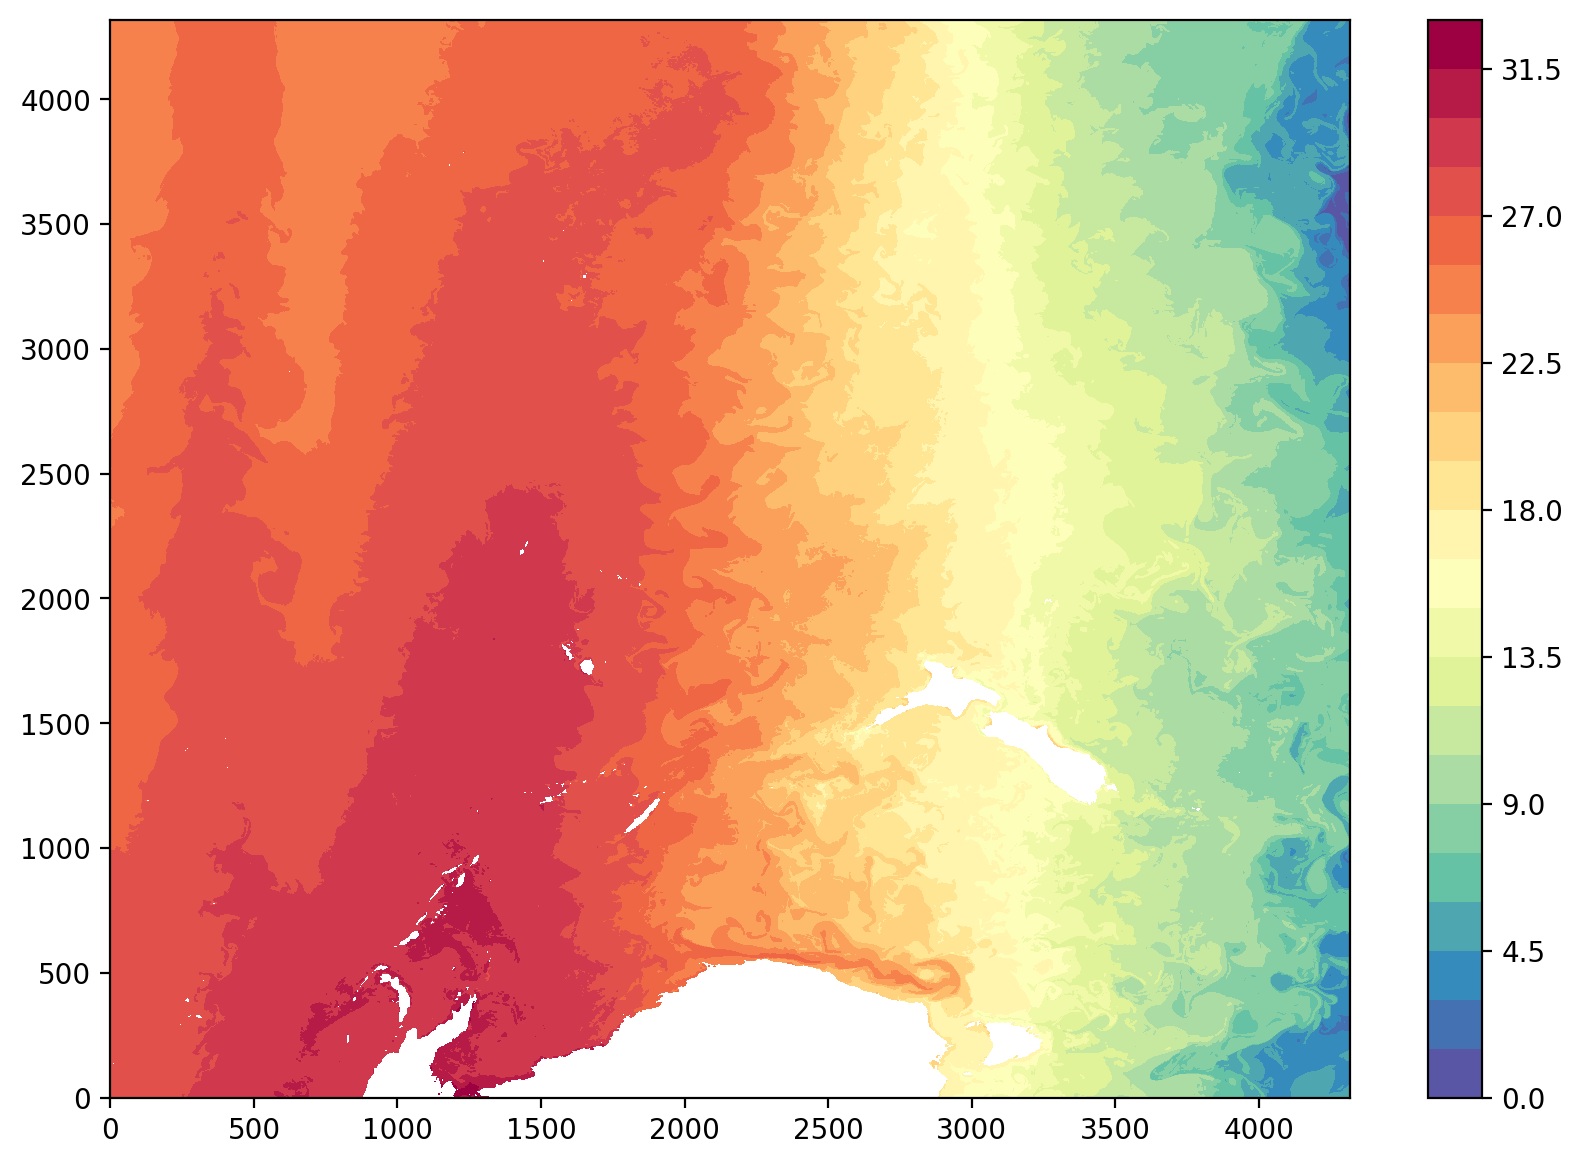

In [ ]:
# select face 7, which is the North Pacific, depth = surface, and time = 3000 hours
llc_sub = llc.isel(face=8, k = 0, time = 3000)

# let's plot
fig, ax = plt.subplots(figsize=(10,7),dpi=200)
cf = ax.contourf(llc_sub['Theta']['i'], llc_sub['Theta']['j'], llc_sub['Theta'], cmap="Spectral_r",vmin=np.min(llc_sub['Theta']).values,vmax=np.max(llc_sub['Theta']).values, levels = 30)

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

#rotate_axes_90_clockwise(ax)

plt.show()

Let's define a function to index a box in the data using lat/lon (XC, YC)

In [13]:
# build i,j,face index for a lat/lon spatial box about central lat/lon coord for llc4320
def llc_latlon_box_indices(
    LLC,
    lat_center,
    lon_center,
    degree_extent):

    half = degree_extent / 2.0

    lat_min = lat_center - half
    lat_max = lat_center + half
    lon_min = lon_center - half
    lon_max = lon_center + half

    XC = LLC["XC"]
    YC = LLC["YC"]

    face_boxes = {}

    for face in XC.face.values:
        xc = XC.sel(face=face)
        yc = YC.sel(face=face)

        # mask points inside the lat/lon box
        mask = (
            (yc >= lat_min) & (yc <= lat_max) &
            (xc >= lon_min) & (xc <= lon_max))

        if not mask.any():
            continue

        # get i/j indices where mask is True
        jj, ii = np.where(mask.values)

        j_start = int(jj.min())
        j_end   = int(jj.max()) + 1
        i_start = int(ii.min())
        i_end   = int(ii.max()) + 1

        face_boxes[int(face)] = (j_start, j_end, i_start, i_end)

    return face_boxes

In [15]:
# apply to llc
boxes = llc_latlon_box_indices(
    llc,
    lat_center=40.0,
    lon_center=180.0,
    degree_extent=10.0
)

for face, (j0, j1, i0, i1) in boxes.items():
    llc_box = llc.isel(face=face, j=slice(j0, j1), i=slice(i0, i1))

In [16]:
# extract box i,j extents
i_0 = llc_box.i.values.min()
i_1 = llc_box.i.values.max()
j_0 = llc_box.j.values.min()
j_1 = llc_box.j.values.max()

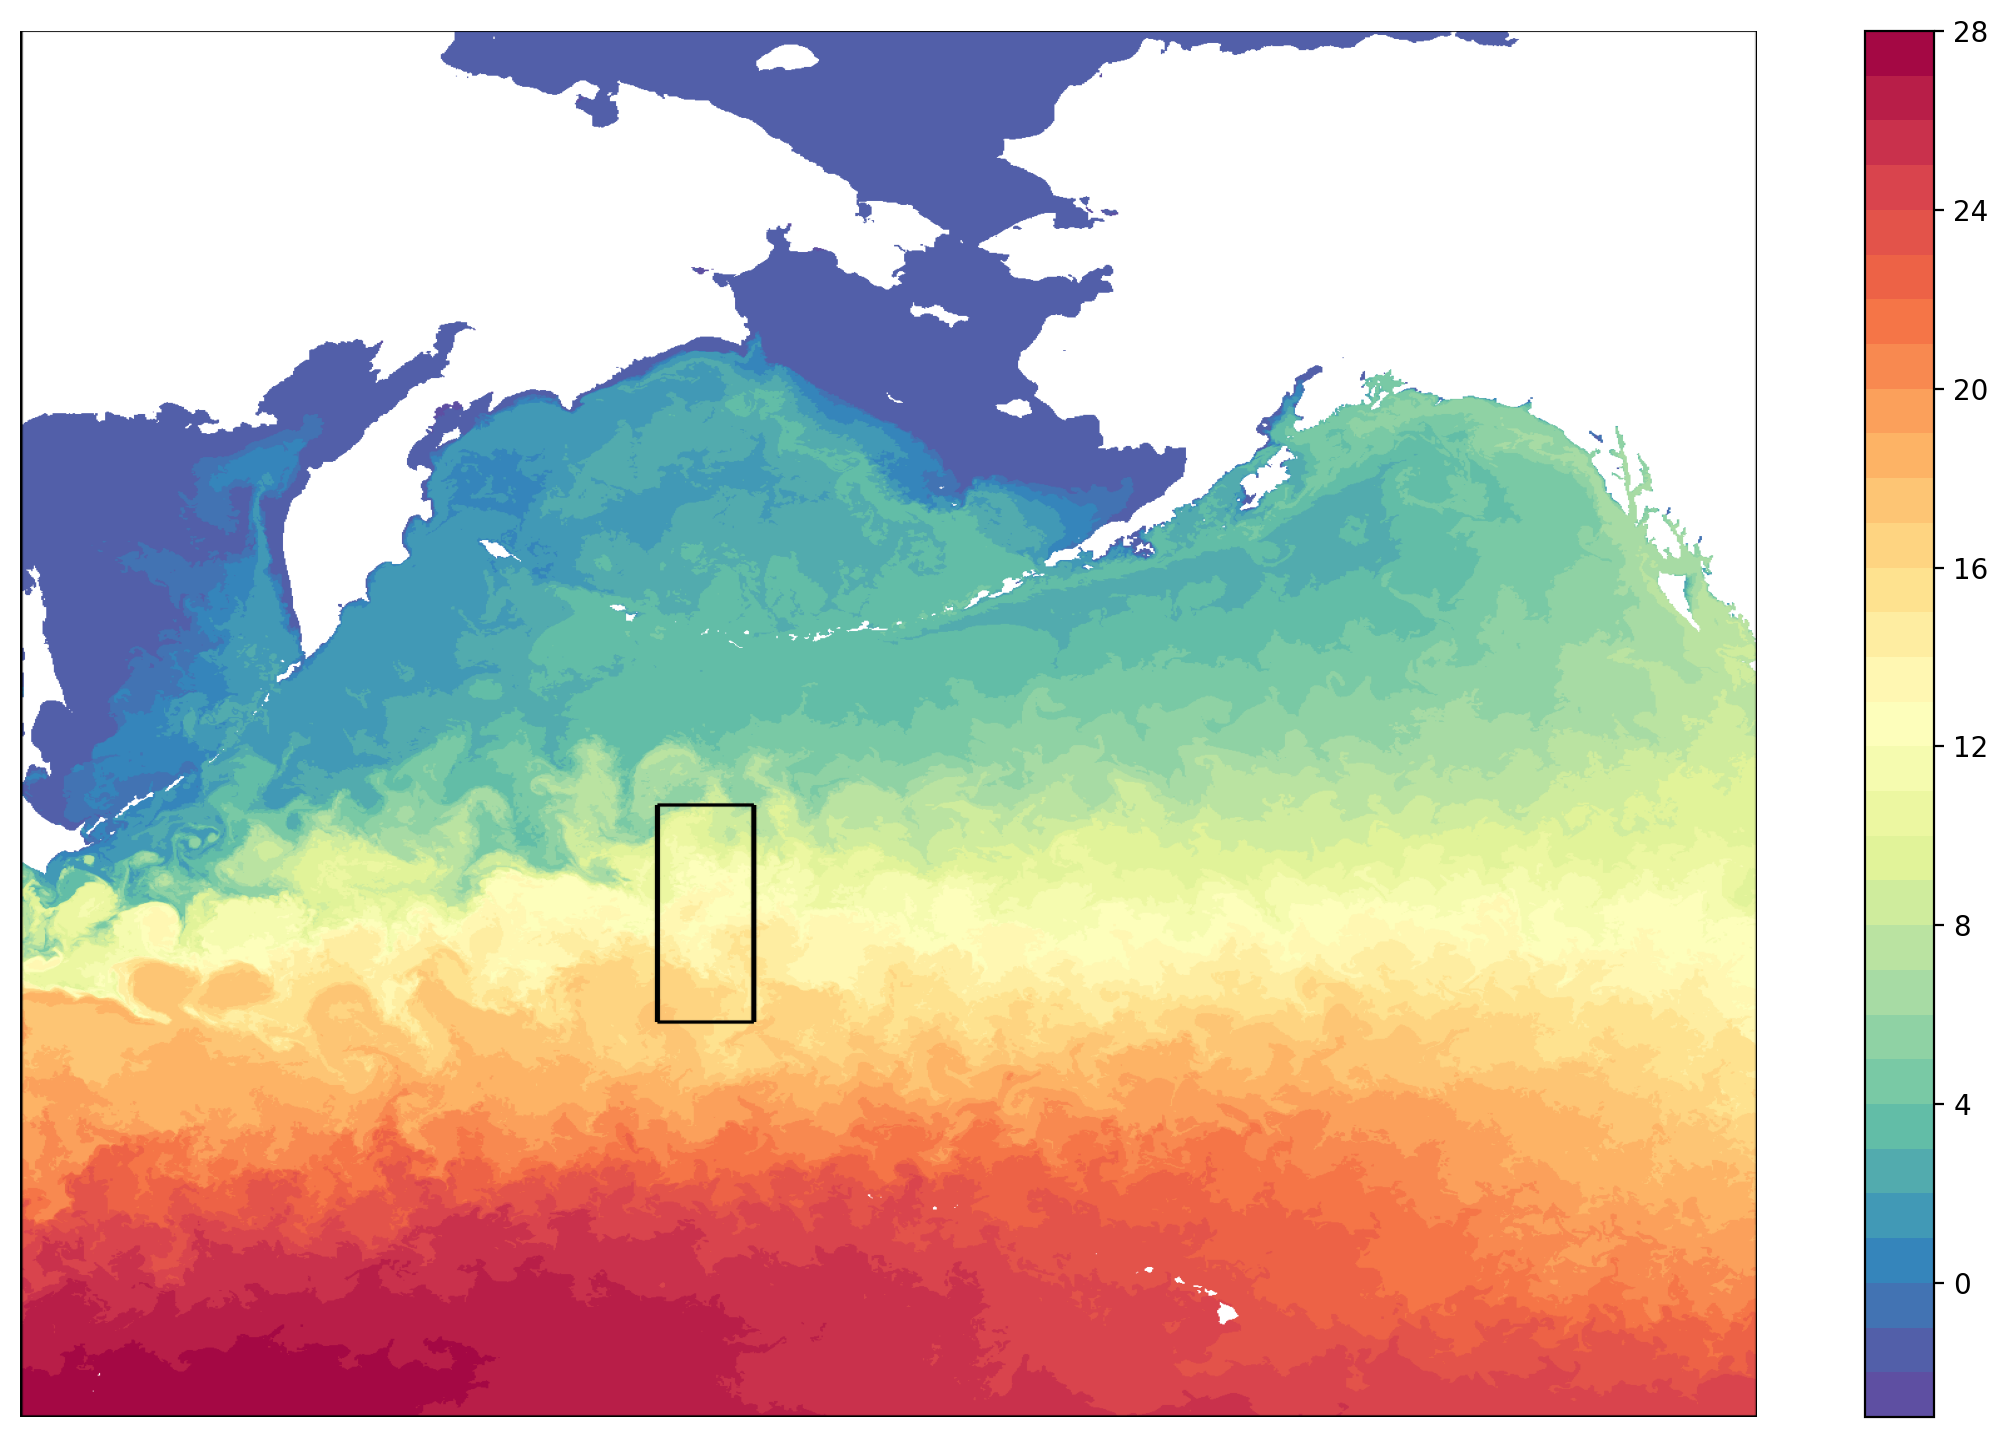

In [17]:
# let's plot
fig, ax = plt.subplots(figsize=(14,9),dpi=200)
cf = ax.contourf(llc_sub['Theta']['i'], llc_sub['Theta']['j'], llc_sub['Theta'], cmap="Spectral_r",vmin=np.min(llc_sub['Theta']).values,vmax=np.max(llc_sub['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='k')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='k')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='k')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='k')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

list of grid metrics, indices, state and surface variables/fluxes, sea-ice variables, and diagnostics/ref constants/masks

1. Grid metrics (cell geometry)
XC, YC → longitude, latitude of tracer (center) points.
XG, YG → longitude, latitude of corner points.
rA → area of tracer cell.
rAw, rAs, rAz → areas of west, south, and vertical cell faces.
dxC, dyC → grid spacing in x and y at cell centers.
dxG, dyG, dxF, dyF, dxV, dyU → grid spacing at staggered locations (U, V, corner).
Depth → ocean bathymetry (positive depth of seafloor).
Z, Zl, Zu, Zp1 → depth coordinates: Z is depth at cell centers, Zl is depth at lower cell faces, Zu is depth at upper faces, Zp1 is depth at interfaces.
drC, drF → vertical grid spacing: drC is thickness at cell centers, drF is thickness at cell faces.
hFacC, hFacW, hFacS → fractional cell open area (0–1) due to topography: hFacC at tracer point, hFacW at u-point, hFacS at v-point.

2. Indices
face → cube face index (LLC grid tiling).
i, j, k → lat/lon directed horizontal indices and vertical indices.
i_g, j_g → staggered grid indices (for U, V points).
k_u, k_l, k_p1 → vertical indexing offsets (upper/lower edges, +1 padding).
iter → model iteration number (timestep counter).
time → actual time coordinate.

3. State variables (prognostic model fields)
U → zonal velocity (m/s). *
V → meridional velocity (m/s). *
W → vertical velocity (m/s). *
Theta → potential temperature (°C). *
Salt → salinity (psu). *
Eta → free surface height (m). *
PhiBot → bottom pressure potential.
PHrefC, PHrefF → hydrostatic pressure reference at centers/faces.

4. Surface fluxes and forcing
oceQnet → net heat flux into ocean (W/m²). *
oceQsw → shortwave heat flux (penetrative).
oceSflux → freshwater flux (salinity).
oceFWflx → freshwater flux (kg/m²/s).
oceTAUX, oceTAUY → surface wind stress components (N/m²). *

5. Sea-ice variables (when using sea ice package)
SIarea → sea-ice area fraction (0–1).
SIheff → effective ice thickness (m).
SIhsnow → snow thickness on ice (m).
SIhsalt → sea-ice bulk salinity.
SIuice, SIvice → sea-ice velocity components (m/s).
SN → snow-related field (e.g. snow mass per unit area).

6. Diagnostics, reference constants, masks
KPPhbl → K-profile parameterization mixed-layer depth (hbl).
rhoRef → reference density profile.
mask_c, mask_w, mask_s → land/ocean masks at tracer (c), U (w), and V (s) points.